In [1]:
from time import time
from batchgenerators.augmentations.crop_and_pad_augmentations import crop
from batchgenerators.dataloading import MultiThreadedAugmenter
from batchgenerators.examples.brats2017.brats2017_dataloader_3D import get_list_of_patients, BraTS2017DataLoader3D, \
    get_train_transform
from batchgenerators.examples.brats2017.config import brats_preprocessed_folder, num_threads_for_brats_example
from batchgenerators.transforms import Compose
from batchgenerators.utilities.data_splitting import get_split_deterministic
from batchgenerators.utilities.file_and_folder_operations import *
import numpy as np
from batchgenerators.dataloading.data_loader import DataLoader
from batchgenerators.augmentations.utils import pad_nd_image
from batchgenerators.transforms.spatial_transforms import SpatialTransform_2, MirrorTransform
from batchgenerators.transforms.color_transforms import BrightnessMultiplicativeTransform, GammaTransform
from batchgenerators.transforms.noise_transforms import GaussianNoiseTransform, GaussianBlurTransform

In [2]:
class BraTS2017DataLoader2D(DataLoader):
    def __init__(self, data, batch_size, patch_size, num_threads_in_multithreaded, seed_for_shuffle=1234, return_incomplete=False,
                 shuffle=True, infinite=True):
        """
        data must be a list of patients as returned by get_list_of_patients (and split by get_split_deterministic)
        patch_size is the spatial size the retured batch will have
        """
        super().__init__(data, batch_size, num_threads_in_multithreaded, seed_for_shuffle, return_incomplete, shuffle,
                         infinite)
        self.patch_size = patch_size
        self.num_modalities = 4
        self.indices = list(range(len(data)))

    @staticmethod
    def load_patient(patient):
        return BraTS2017DataLoader3D.load_patient(patient)

    def generate_train_batch(self):
        # DataLoader has its own methods for selecting what patients to use next, see its Documentation
        idx = self.get_indices()
        patients_for_batch = [self._data[i] for i in idx]

        # initialize empty array for data and seg
        data = np.zeros((self.batch_size, self.num_modalities, *self.patch_size), dtype=np.float32)
        seg = np.zeros((self.batch_size, 1, *self.patch_size), dtype=np.float32)

        metadata = []
        patient_names = []

        # iterate over patients_for_batch and include them in the batch
        for i, j in enumerate(patients_for_batch):
            patient_data, patient_metadata = self.load_patient(j)

            # patient data is a memmap. If we extract just one slice then just this one slice will be read from the
            # disk, so no worries!
            slice_idx = np.random.choice(patient_data.shape[1])
            patient_data = patient_data[:, slice_idx]

            # this will only pad patient_data if its shape is smaller than self.patch_size
            patient_data = pad_nd_image(patient_data, self.patch_size)

            # now random crop to self.patch_size
            # crop expects the data to be (b, c, x, y, z) but patient_data is (c, x, y, z) so we need to add one
            # dummy dimension in order for it to work (@Todo, could be improved)
            patient_data, patient_seg = crop(patient_data[:-1][None], patient_data[-1:][None], self.patch_size, crop_type="random")

            data[i] = patient_data[0]
            seg[i] = patient_seg[0]

            metadata.append(patient_metadata)
            patient_names.append(j)

        return {'data': data, 'seg':seg, 'metadata':metadata, 'names':patient_names}

In [6]:
brats_preprocessed_folder = 'brats_data_preprocessed/Brats17TrainingData'

In [7]:
patients = get_list_of_patients(brats_preprocessed_folder)

In [8]:
patients

['brats_data_preprocessed/Brats17TrainingData/Brats17_2013_0_1',
 'brats_data_preprocessed/Brats17TrainingData/Brats17_2013_10_1',
 'brats_data_preprocessed/Brats17TrainingData/Brats17_2013_11_1',
 'brats_data_preprocessed/Brats17TrainingData/Brats17_2013_12_1',
 'brats_data_preprocessed/Brats17TrainingData/Brats17_2013_13_1',
 'brats_data_preprocessed/Brats17TrainingData/Brats17_2013_14_1',
 'brats_data_preprocessed/Brats17TrainingData/Brats17_2013_15_1',
 'brats_data_preprocessed/Brats17TrainingData/Brats17_2013_16_1',
 'brats_data_preprocessed/Brats17TrainingData/Brats17_2013_17_1',
 'brats_data_preprocessed/Brats17TrainingData/Brats17_2013_18_1',
 'brats_data_preprocessed/Brats17TrainingData/Brats17_2013_19_1',
 'brats_data_preprocessed/Brats17TrainingData/Brats17_2013_1_1',
 'brats_data_preprocessed/Brats17TrainingData/Brats17_2013_20_1',
 'brats_data_preprocessed/Brats17TrainingData/Brats17_2013_21_1',
 'brats_data_preprocessed/Brats17TrainingData/Brats17_2013_22_1',
 'brats_data

In [9]:
# num_splits=5 means 1/5th is validation data!
train, val = get_split_deterministic(patients, fold=0, num_splits=5, random_state=12345)

In [11]:
len(train)

228

In [12]:
len(val)

57

In [14]:
patch_size = (160, 160)
batch_size = 48

In [15]:
dataloader = BraTS2017DataLoader2D(train, batch_size, patch_size, 1)

In [17]:
batch = next(dataloader)

In [19]:
batch.keys()

dict_keys(['data', 'seg', 'metadata', 'names'])

In [25]:
batch['data'].shape

(48, 4, 160, 160)

In [26]:
import matplotlib.pyplot as plt

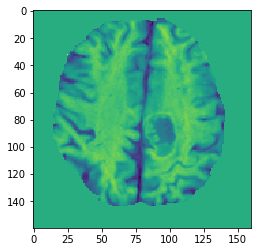

In [49]:
plt.imshow(batch['data'][14,0])

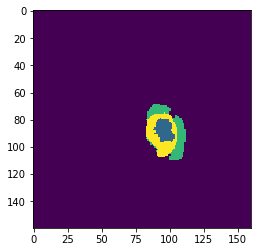

In [50]:
plt.imshow(batch['seg'][14,0])

In [51]:
batch['metadata']

[{'spacing': array([1., 1., 1.]),
  'direction': (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0),
  'origin': (-0.0, -239.0, 0.0),
  'original_shape': (155, 240, 240),
  'nonzero_region': array([[  0, 148],
         [ 43, 218],
         [ 48, 190]])},
 {'spacing': array([1., 1., 1.]),
  'direction': (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0),
  'origin': (-0.0, -239.0, 0.0),
  'original_shape': (155, 240, 240),
  'nonzero_region': array([[  0, 133],
         [ 45, 214],
         [ 52, 185]])},
 {'spacing': array([1., 1., 1.]),
  'direction': (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0),
  'origin': (-0.0, -239.0, 0.0),
  'original_shape': (155, 240, 240),
  'nonzero_region': array([[  0, 140],
         [ 41, 218],
         [ 49, 188]])},
 {'spacing': array([1., 1., 1.]),
  'direction': (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0),
  'origin': (0.0, -239.0, 0.0),
  'original_shape': (155, 240, 240),
  'nonzero_region': array([[  2, 138],
         [ 45, 216],
         [ 51, 183]])},
 

In [52]:
batch['names']

['brats_data_preprocessed/Brats17TrainingData/Brats17_CBICA_ASY_1',
 'brats_data_preprocessed/Brats17TrainingData/Brats17_TCIA_637_1',
 'brats_data_preprocessed/Brats17TrainingData/Brats17_CBICA_ASK_1',
 'brats_data_preprocessed/Brats17TrainingData/Brats17_TCIA_420_1',
 'brats_data_preprocessed/Brats17TrainingData/Brats17_TCIA_460_1',
 'brats_data_preprocessed/Brats17TrainingData/Brats17_CBICA_ASE_1',
 'brats_data_preprocessed/Brats17TrainingData/Brats17_2013_10_1',
 'brats_data_preprocessed/Brats17TrainingData/Brats17_CBICA_ABB_1',
 'brats_data_preprocessed/Brats17TrainingData/Brats17_2013_7_1',
 'brats_data_preprocessed/Brats17TrainingData/Brats17_TCIA_451_1',
 'brats_data_preprocessed/Brats17TrainingData/Brats17_CBICA_AWH_1',
 'brats_data_preprocessed/Brats17TrainingData/Brats17_TCIA_368_1',
 'brats_data_preprocessed/Brats17TrainingData/Brats17_CBICA_AWH_1',
 'brats_data_preprocessed/Brats17TrainingData/Brats17_CBICA_AVV_1',
 'brats_data_preprocessed/Brats17TrainingData/Brats17_TCIA

## Data Augmentation

In [53]:
# first let's collect all shapes, you will see why later
shapes = [BraTS2017DataLoader2D.load_patient(i)[0].shape[2:] for i in patients]
max_shape = np.max(shapes, 0)
max_shape = np.max((max_shape, patch_size), 0)

In [54]:
shapes

[(159, 133),
 (176, 136),
 (165, 143),
 (169, 128),
 (170, 147),
 (174, 141),
 (167, 131),
 (176, 145),
 (183, 145),
 (177, 146),
 (169, 141),
 (175, 146),
 (175, 146),
 (156, 129),
 (164, 157),
 (177, 139),
 (165, 141),
 (171, 144),
 (180, 141),
 (166, 149),
 (161, 149),
 (163, 137),
 (179, 142),
 (155, 144),
 (169, 144),
 (176, 142),
 (167, 144),
 (159, 137),
 (168, 151),
 (171, 131),
 (173, 137),
 (187, 134),
 (163, 129),
 (182, 135),
 (175, 133),
 (177, 133),
 (170, 139),
 (179, 140),
 (170, 130),
 (171, 130),
 (160, 152),
 (178, 138),
 (164, 145),
 (179, 141),
 (176, 144),
 (176, 133),
 (177, 140),
 (167, 137),
 (167, 133),
 (180, 140),
 (157, 133),
 (187, 132),
 (168, 127),
 (170, 138),
 (160, 131),
 (184, 141),
 (172, 134),
 (179, 144),
 (161, 132),
 (182, 132),
 (177, 140),
 (172, 129),
 (167, 133),
 (162, 128),
 (167, 148),
 (158, 137),
 (162, 142),
 (172, 130),
 (167, 125),
 (187, 137),
 (165, 143),
 (165, 142),
 (168, 146),
 (173, 136),
 (162, 135),
 (174, 133),
 (178, 139),

In [67]:
max_shape

array([189, 160])

In [55]:
dataloader_train = BraTS2017DataLoader2D(train, batch_size, max_shape, 1)

In [56]:
dataloader_validation = BraTS2017DataLoader2D(val, batch_size, patch_size, 1)

In [57]:
tr_transforms = get_train_transform(patch_size)

In [61]:
tr_transforms

Compose ( [SpatialTransform_2( p_rot_per_sample = 0.1, p_scale_per_sample = 0.1, p_el_per_sample = 0.1, data_key = 'data', label_key = 'seg', patch_size = (160, 160), patch_center_dist_from_border = [80, 80], do_elastic_deform = True, deformation_scale = (0, 0.25), do_rotation = True, angle_x = (-0.2617993877991494, 0.2617993877991494), angle_y = (-0.2617993877991494, 0.2617993877991494), angle_z = (-0.2617993877991494, 0.2617993877991494), do_scale = True, scale = (0.75, 1.25), border_mode_data = 'constant', border_cval_data = 0, order_data = 3, border_mode_seg = 'constant', border_cval_seg = 0, order_seg = 1, random_crop = True ), MirrorTransform( data_key = 'data', label_key = 'seg', axes = (0, 1, 2) ), BrightnessMultiplicativeTransform( p_per_sample = 0.15, data_key = 'data', multiplier_range = (0.7, 1.5), per_channel = True ), GammaTransform( p_per_sample = 0.15, retain_stats = False, per_channel = True, data_key = 'data', gamma_range = (0.5, 2), invert_image = False ), GammaTrans

In [58]:
# finally we can create multithreaded transforms that we can actually use for training
# we don't pin memory here because this is pytorch specific.
tr_gen = MultiThreadedAugmenter(dataloader_train, tr_transforms, num_processes=num_threads_for_brats_example,
                                num_cached_per_queue=3,
                                seeds=None, pin_memory=False)
# we need less processes for vlaidation because we dont apply transformations
val_gen = MultiThreadedAugmenter(dataloader_validation, None,
                                 num_processes=max(1, num_threads_for_brats_example // 2), num_cached_per_queue=1,
                                 seeds=None,
                                 pin_memory=False)

In [59]:
# lets start the MultiThreadedAugmenter. This is not necessary but allows them to start generating training
# batches while other things run in the main thread
tr_gen.restart()
val_gen.restart()

In [60]:
# now if this was a network training you would run epochs like this (remember tr_gen and val_gen generate
# inifinite examples! Don't do "for batch in tr_gen:"!!!):
num_batches_per_epoch = 10
num_validation_batches_per_epoch = 3
num_epochs = 5
# let's run this to get a time on how long it takes
time_per_epoch = []
start = time()
for epoch in range(num_epochs):
    start_epoch = time()
    for b in range(num_batches_per_epoch):
        batch = next(tr_gen)
        # do network training here with this batch

    for b in range(num_validation_batches_per_epoch):
        batch = next(val_gen)
        # run validation here
    end_epoch = time()
    time_per_epoch.append(end_epoch - start_epoch)
end = time()
total_time = end - start
print("Running %d epochs took a total of %.2f seconds with time per epoch being %s" %
      (num_epochs, total_time, str(time_per_epoch)))

Running 5 epochs took a total of 4.94 seconds with time per epoch being [0.462465763092041, 0.541724681854248, 0.9904797077178955, 0.990619421005249, 1.9542591571807861]


## Visualize augmented example

In [62]:
batch = next(tr_gen)

In [72]:
augmented = np.concatenate((batch['data'][2], batch['seg'][2]), 0)[:, None]

In [73]:
augmented.shape

(5, 1, 160, 160)

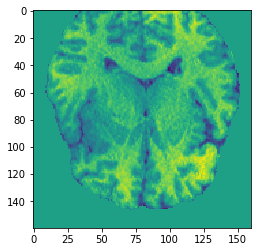

In [74]:
plt.imshow(augmented[0, 0])